### 0. Download dataset and save it in the project location

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("bhargavchirumamilla/thyroid-cancer-risk-dataset")

# print("Path to dataset files:", path)

In [3]:
# import os

# os.rename(path, "./download")

###  1. Prepare data for training

In [4]:
import pandas as pd

df = pd.read_csv("./download/thyroid_cancer_risk_data.csv")
df.dropna()
df = df.drop("Country", axis=1)
df = pd.get_dummies(df, columns=["Gender", "Ethnicity", "Smoking", "Obesity", "Diabetes", "Family_History", "Radiation_Exposure", "Iodine_Deficiency"] , dtype=float)



In [5]:
# Creating a balanced dataset

df_benign = df[df["Diagnosis"] == "Benign"]
df_benign =df_benign.sample(frac=1, random_state=42).reset_index(drop=True)

df_malignant = df[df["Diagnosis"]=="Malignant"]
df_malignant = df_malignant.sample(frac=1, random_state=42).reset_index(drop=True)

df = df_benign[:49000]
df = pd.concat((df, df_malignant[:49000]), axis=0)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
y_risk = df["Thyroid_Cancer_Risk"]
y_risk = pd.get_dummies(y_risk)
y_diagnosis = df["Diagnosis"]
y_diagnosis = pd.get_dummies(y_diagnosis, dtype=float)


df = df.drop(["Thyroid_Cancer_Risk", "Diagnosis", "Patient_ID"], axis=1)

y = y_diagnosis.values
y.shape

(98000, 2)

In [7]:
df["Age"] = df["Age"]/100
df["TSH_Level"] = df["TSH_Level"]/10
df["T3_Level"] = df["T3_Level"]/3.5
df["T4_Level"] = df["T4_Level"]/12
df["Nodule_Size"] = df["Nodule_Size"]/5

df.max(axis=0)

Age                         0.89
TSH_Level                   1.00
T3_Level                    1.00
T4_Level                    1.00
Nodule_Size                 1.00
Gender_Female               1.00
Gender_Male                 1.00
Ethnicity_African           1.00
Ethnicity_Asian             1.00
Ethnicity_Caucasian         1.00
Ethnicity_Hispanic          1.00
Ethnicity_Middle Eastern    1.00
Smoking_No                  1.00
Smoking_Yes                 1.00
Obesity_No                  1.00
Obesity_Yes                 1.00
Diabetes_No                 1.00
Diabetes_Yes                1.00
Family_History_No           1.00
Family_History_Yes          1.00
Radiation_Exposure_No       1.00
Radiation_Exposure_Yes      1.00
Iodine_Deficiency_No        1.00
Iodine_Deficiency_Yes       1.00
dtype: float64

### Note

Age max = 89, I divide by 100, will set later max value to 100,

TSH_Level max = 10, -> divide by 10 

T3_Level max = 3.5 -> divide by 3.5

T4_Level max = 12 -> divide by 12

Nodule_Size max = 5 -> divide by 5


In [8]:
import numpy as np

X = df.values
X = np.float32(X)
y = np.float32(y)

In [9]:
from sklearn.model_selection import train_test_split

# Prepare data for prediction of diagnosis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=True)

### 2. Solving with decision Tree

- 63.9% accuracy

In [10]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion="gini", splitter="best", max_depth=10)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6514285714285715

In [11]:
print(df.columns)
print(X_train[0])

Index(['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size',
       'Gender_Female', 'Gender_Male', 'Ethnicity_African', 'Ethnicity_Asian',
       'Ethnicity_Caucasian', 'Ethnicity_Hispanic', 'Ethnicity_Middle Eastern',
       'Smoking_No', 'Smoking_Yes', 'Obesity_No', 'Obesity_Yes', 'Diabetes_No',
       'Diabetes_Yes', 'Family_History_No', 'Family_History_Yes',
       'Radiation_Exposure_No', 'Radiation_Exposure_Yes',
       'Iodine_Deficiency_No', 'Iodine_Deficiency_Yes'],
      dtype='object')
[0.67       0.594      0.26285714 0.5391667  0.212      0.
 1.         1.         0.         0.         0.         0.
 1.         0.         1.         0.         1.         0.
 1.         0.         1.         0.         1.         0.        ]


### 2.1 Exporting decision tree to onnx

In [12]:
# # Convert into ONNX format.
# from skl2onnx import to_onnx

# onx = to_onnx(model, X[:1])
# with open("decision_tree_thyroid_cancer_prediction.onnx", "wb") as f:
#     f.write(onx.SerializeToString())

### 3. Solving with neural network

In [13]:
import torch

class ThyroidCancerModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(in_features=24, out_features=512),
            torch.nn.Dropout(p=0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=512, out_features=16),
            torch.nn.Dropout(p=0.2),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=1)
        )
        
    def forward(self, x):
        return self.layers(x)
    
model2 = ThyroidCancerModel()
model2

ThyroidCancerModel(
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=16, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [14]:
optimizer = torch.optim.Adam(params = model2.parameters(), lr= 0.0001)
lossfn = torch.nn.BCEWithLogitsLoss()

In [15]:
# creating tensors

X_train_t = torch.from_numpy(X_train).to(device="cuda")
X_test_t = torch.from_numpy(X_test).to(device="cuda")

y_train_t = torch.from_numpy(y_train).to(device="cuda")
y_train_t = torch.argmax(y_train_t, dim=1)
y_train_t = y_train_t.unsqueeze(dim=1).float()

y_test_t = torch.from_numpy(y_test).to(device="cuda")
y_test_t = torch.argmax(y_test_t, dim=1)
y_test_t = y_test_t.unsqueeze(dim=1).float()

model2 = model2.to(device="cuda")

model2(X_train_t[0])

tensor([0.0227], device='cuda:0', grad_fn=<ViewBackward0>)

In [16]:
results = pd.DataFrame(columns=["epoch", "training_loss", "testing_loss", "test_accuracy", "test_precision", "test_recall"])

In [17]:
from torchmetrics import Accuracy
from torchmetrics import Precision
from torchmetrics import Recall

accuracy = Accuracy(task="binary").to(device="cuda")
precision = Precision(task="binary").to(device="cuda")
recall = Recall(task="binary").to(device="cuda")

In [18]:


epochs = 2001

for epoch in range(epochs):
    model2.train()
    logits = model2(X_train_t)
    loss = lossfn(logits, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        model2.eval()
        with torch.inference_mode():
            test_logits = model2(X_test_t)
            test_loss = lossfn(test_logits, y_test_t)
            
            res = torch.sigmoid(test_logits)
            res = (res > 0.5).int()
            
            ac = accuracy(res, y_test_t)
            pc = precision(res, y_test_t)
            rc = recall(res, y_test_t)
            
            results.loc[len(results)] = [epoch, loss.item(), test_loss.item(), ac.item(), pc.item(), rc.item()]
            
            print(F"epoch:{epoch} | loss: {loss.item()} | test_loss: {test_loss.item()} | accuracy: {ac.item()} | precision: {pc.item()} | recall:{rc.item()}")
            
        

epoch:0 | loss: 0.6932641267776489 | test_loss: 0.693109929561615 | accuracy: 0.5030612349510193 | precision: 0.5011792182922363 | recall:0.17439474165439606
epoch:100 | loss: 0.6633322238922119 | test_loss: 0.6629506945610046 | accuracy: 0.6248979568481445 | precision: 0.6420104503631592 | recall:0.5556011199951172
epoch:200 | loss: 0.6427003741264343 | test_loss: 0.6411512494087219 | accuracy: 0.631428599357605 | precision: 0.6637259721755981 | recall:0.5248256325721741
epoch:300 | loss: 0.628288984298706 | test_loss: 0.6255869269371033 | accuracy: 0.6383673548698425 | precision: 0.6804123520851135 | recall:0.5145670771598816
epoch:400 | loss: 0.6192906498908997 | test_loss: 0.6151055693626404 | accuracy: 0.6530612111091614 | precision: 0.6946645379066467 | recall:0.5395978689193726
epoch:500 | loss: 0.6159019470214844 | test_loss: 0.6113071441650391 | accuracy: 0.6587755084037781 | precision: 0.6932794451713562 | recall:0.5629872679710388
epoch:600 | loss: 0.6151626706123352 | test_

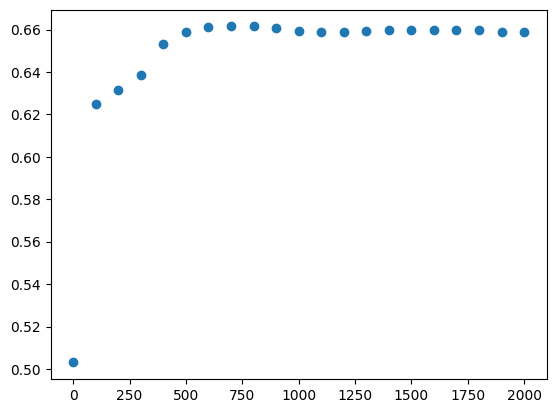

In [19]:
import matplotlib.pyplot as plt


plt.scatter(y=results["test_accuracy"].values, x=results["epoch"].values)
plt.show()

In [23]:
import torch
onnx_program = torch.onnx.export(model2, X_train_t[0], dynamo=True)

/home/radekbys/Code/expert-system-thyroid-cancer/.venv/lib/python3.12/site-packages/onnxscript/converter.py:816: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/radekbys/Code/expert-system-thyroid-cancer/.venv/lib/python3.12/site-packages/onnxscript/converter.py:816: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


[torch.onnx] Obtain model graph for `ThyroidCancerModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ThyroidCancerModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


In [24]:
onnx_program.optimize()

In [25]:
onnx_program.save("nn_model.onnx")